# User Defined Types

User Defined Types (UDT) allow you to define a custom Matrix element type.  For example in the shortest path problem, it can be useful to calculate not just the path length, but the number of hops along the shortest path, and a tree of shortest paths from every node back to the source.  This example is a high level translate of the `LAGraph_BF_full` function implementing the [Bellman-Ford algorithm](https://en.wikipedia.org/wiki/Bellman%E2%80%93Ford_algorithm)

In [1]:
from pygraphblas import *

class BF(Type):
    
    members = ['double w', 'uint64_t h', 'uint64_t pi']
    one = (lib.INFINITY, lib.UINT64_MAX, lib.UINT64_MAX)
    
    @binop(boolean=True) 
    def EQ(z, x, y):
        if not x.w == y.w and x.h == y.h and x.pi == y.pi:
            z = True
        else:
            z = False

    @binop()
    def PLUS(z, x, y):
        if (x.w < y.w 
            or x.w == y.w and x.h < y.h 
            or x.w == y.w and x.h == y.h and x.pi < y.pi):
            if (z.w != x.w and z.h != x.h and z.pi != x.pi):
                z.w = x.w
                z.h = x.h
                z.pi = x.pi        
        else:
            z.w = y.w
            z.h = y.h
            z.pi = y.pi   

    @binop()
    def TIMES(z, x, y):
        z.w = x.w + y.w
        z.h = x.h + y.h
        if x.pi != lib.UINT64_MAX and y.pi != 0:
            z.pi = y.pi
        else:
            z.pi = x.pi

In [2]:
BF_monoid = BF.new_monoid(BF.PLUS, BF.one)
BF_semiring = BF.new_semiring(BF_monoid, BF.TIMES)

def shortest_path(matrix, start):
    n = matrix.nrows
    v = Vector.from_type(matrix.type, n)
    for i, j, k in matrix:
        if i == j:
            matrix[i,j] = (0, 0, 0)
        else:
            matrix[i,j] = (k[0], 1, i)        
    v[start] = (0, 0, 0)
    with BF_semiring, Accum(BF.PLUS):
        for _ in range(matrix.nrows):
            w = v.dup()
            v @= matrix
            if w.iseq(v):
                break
    return v

A = Matrix.from_type(BF, 6, 6)
A[0,1] = (9.0, 0, 0)
A[0,3] = (3.0, 0, 0)
A[1,2] = (8.0, 0, 0)
A[3,4] = (6.0, 0, 0)
A[3,5] = (1.0, 0, 0)
A[4,2] = (4.0, 0, 0)
A[1,5] = (7.0, 0, 0)
A[5,4] = (2.0, 0, 0)

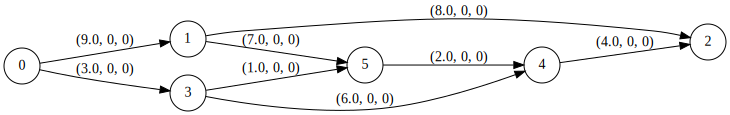

In [3]:
from pygraphblas.demo.gviz import draw
draw(A)

## Computing the shortest path

Below is the result of labeling each node with the result of the shortest path computation.  Each result is a tuple, the first value is the accumulated weight from the starting node.  The second value is the number of hops from the starting node.  The third value is the node "back" to the starting node, forming a shortest path tree with the starting node as the root.

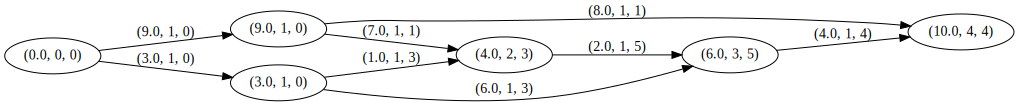

In [4]:
draw(A, label_vector=shortest_path(A, 0))